<h1><center>Essential functions for stock charts technical analysis</center></h1> 

<h2><center>Moving Average (MA) + Bollinger Band + RSI</center></h2> 

In [246]:
# Fundamentals imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#pd.options.mode.chained_assignment = None
pd.set_option("display.precision", 3)

In [247]:
test_data = pd.read_csv("../Data/Consumer Discretionary/Airbnb Inc. Class A Common Stock.csv")

---------------------------------------------------------------

<h1><center>Moving Average</center></h1> 

In [248]:
def calculate_ma(stocks_data, day_range = 14):
    '''
        Calculating Simple Moving Average based on the data frame and time period (which is set by the user). 
        Returns data frame with the "MA" column.

        Arguments:
            stocks_data - data frame with stocks data
            day_range - period on which Moving Average is calculated. By default - 14 (since it's considered a standard)
    '''
    
    moving_average = stocks_data['Close'].rolling(day_range).mean()
   # stocks_data[f'MA_{day_range}'] = moving_average
    stocks_data.loc[:, f'MA_{day_range}'] = moving_average
    moving_average = moving_average.fillna(0)
   
    #return stocks_data

---------------------------------------------------------

<h1><center>Bollinger Band</center></h1> 

In [249]:
def calculate_bollinger_band(stocks_data, day_range = 14):
    '''
        Calculating Bollinger Bands Upper and Lower Bounds based on the stocks data dataframe.
        Returns a data frame with 2 new columns:
            1) BB_Upper_Bound
            2) BB_Lower_Bound

        Arguments:
            stocks_data - data frame with stocks data
            day_range - period on which Moving Average is calculated. By default - 14 (since it's considered a standard)
    '''
    #stocks_data_copy = stocks_data.copy(deep = True)
    #stocks_data = calculate_ma(stocks_data, day_range)
    if f"MA_{day_range}" not in stocks_data.columns:
        calculate_ma(stocks_data, day_range)
        
    ma = stocks_data[f"MA_{day_range}"]
    
    # stocks_data["Standard Deviation"] = (stocks_data['Close'].rolling(window = day_range).std()).fillna(0)
    # standard_deviation = stocks_data["Standard Deviation"]
    # stocks_data["BB_Upper_Bound"] = (ma + 2 * standard_deviation).fillna(0)
    # stocks_data["BB_Lower_Bound"] = (ma - 2 * standard_deviation).fillna(0)

    stocks_data["Standard Deviation"] = (stocks_data['Close'].rolling(window = day_range).std())
    standard_deviation = stocks_data["Standard Deviation"]
    stocks_data["BB_Upper_Bound"] = (ma + 2 * standard_deviation)
    stocks_data["BB_Lower_Bound"] = (ma - 2 * standard_deviation)
       

    # stocks_data["BB_Upper_Bound"] = (stocks_data[f"MA_{day_range}"] + 2 * standard_deviation).fillna(0)
    # stocks_data["BB_Lower_Bound"] = (stocks_data[f"MA_{day_range}"] - 2 * standard_deviation).fillna(0)

   # return stocks_data

--------------------------------------------------------------------

<h1><center>Candlesticks graphic drawing</center></h1> 

In [283]:
def create_candles_graph(stocks_data, 
                         file_name = "Test-image", 
                         image_width = 100, 
                         image_height = 10, 
                         up_day_color = 'green', 
                         down_day_color = 'red'):

    '''
        Create a candlestick graphic of a given stocks data frame

        Arguments:
        
            Mandatory:
                stocks_data - data frame with stocks data
                
            Optional:
                image_width - Graphic image width in inches (by default 100)
                image_height -  Graphic image height in inches (by default 10)
                    Also user can customize up an down days color according to preferences:
                up_day_color - by default green
                down_day_color - by default - red
                
    '''
    
    fig, ax = plt.subplots(figsize = (image_width, image_height));
   # ax.plot(stocks_data["Date"], stocks_data["MA_14"])
    up = stocks_data[stocks_data["Close"] > stocks_data["Open"]]
    down = stocks_data[stocks_data["Close"] < stocks_data["Open"]]
      
    ax.bar(up["Date"], up["Close"]-up["Open"], bottom=up["Open"], width =.2, color = up_day_color);
    ax.bar(up["Date"], up["High"] - up["Close"], bottom = up["Close"], width = .02, color = up_day_color);
    ax.bar(up["Date"], up["Low"] - up["Open"], bottom = up["Open"], width = .02, color = up_day_color);
    
    ax.bar(down["Date"], down["Close"] - down["Open"], bottom = down["Open"], width = .2, color = down_day_color);
    ax.bar(down["Date"], down["High"] - down["Open"], bottom = down["Open"], width = .02, color = down_day_color);
    ax.bar(down["Date"], down["Low"] - down["Close"], bottom = down["Close"], width = .02, color = down_day_color);

    
    

    #fig.savefig(f"../{file_name}.png")


--------------------------------------------------------

<h1><center>Creating Plot with Moving average and Bollinger Bands</center></h1> 

In [288]:
def create_plot_with_MA_and_BB(df, 
                               amount_of_days_to_show = None, 
                               day_range = 14):
    '''
        Creating a graphic with closing price + Moving average + Bollinger Bands

        Arguments:
            df - stocks data frame
            day_range - period range on which the data will be calculated. By default - 14
    '''
    if amount_of_days_to_show == None:
        amount_of_days_to_show = len(df)
        
    if amount_of_days_to_show <= len(df) and amount_of_days_to_show > 1:
        df = df.copy()[-amount_of_days_to_show :]
        
        calculate_bollinger_band(df, day_range)
     
        fig, ax = plt.subplots(figsize = (100, 10));
        
        ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 4);
        ax.plot(df["Date"], df["Close"], color = 'pink', linewidth = 12);
        df.dropna(inplace = True)
        ax.plot(df["Date"], df[f"MA_{day_range}"], color = 'red');
        
    
        ax.fill_between(df["Date"], df["BB_Upper_Bound"], df["BB_Lower_Bound"], 
                        interpolate = True,
                        color = "wheat",
                        edgecolor = ["coral", "fuchsia"],
                        linewidth = 4);
        
        ax.legend(["Close", "Moving average", "Bollinger Band"], loc = "upper right");
        plt.grid(True);
        

-----------------------------------------------------------------

<h1><center>Running MA + RSI</center></h1> 

In [267]:
def running_moving_average(df, range_in_days = 14):
    '''
        Calculates Running moving average. Returns moving average for the given period of time.

        Arguments:
            df - data frame with stocks data on which moving average will be calculated
            range_in_days - period on which Moving average will be calculated. By default - 14
    '''
    moving_average = np.full_like(df, np.nan)
    moving_average[range_in_days] = df[1: range_in_days + 1].mean()
    
    
    for i in range(range_in_days + 1, len(df)):
        moving_average[i] = (moving_average[i-1] * (range_in_days - 1) + df[i]) / range_in_days
    
    return moving_average

def calculate_rsi(stocks_data, range_in_days = 14):

    '''
        Calculating RSI and storing it in corresponding column in the given data frame.

        Arguments:
            stocks_data - data frame with stocks data where moving average must be calculated
            range_in_days - time period (in days) on which RSI is calculated. By default - 14
    '''
    
    close_price = stocks_data['Close']
    gain_and_loss = close_price.diff(1)
    is_gain, is_loss = gain_and_loss > 0, gain_and_loss < 0
    gain, loss = gain_and_loss, -gain_and_loss
    
    gain[is_loss] = 0
    loss[is_gain] = 0

    data = {"Gain" : gain, "Loss" : loss}
    
    stocks_data["Gain"] = gain
    stocks_data["Loss"] = loss
    stocks_data["AVG Gain"] = running_moving_average(stocks_data["Gain"].to_numpy(), range_in_days)
    stocks_data['AVG Loss'] = running_moving_average(stocks_data["Loss"].to_numpy(), range_in_days)

    stocks_data['RS'] = stocks_data["AVG Gain"] / stocks_data["AVG Loss"]

    stocks_data['RSI'] = 100 - (100/ (1 + stocks_data['RS']))

------------------------------------------------------------

<h1><center>ATR</center></h1> 

In [253]:
def calculate_atr(stocks_data, day_range = 14):
    '''
        Function that calculates ATR for the table with stocks data

        Arguments:
            stocks_data - data frame on which ATR should be calculated
            day_range - days range, on which ATR must be calculated (by default - 14)
    '''
    stocks_data["High vs Low"] = stocks_data["High"] - stocks_data["Low"]
    for i in range(1, len(stocks_data)):
        stocks_data.loc[i, "High Vs Yesterday Close"] = np.abs(stocks_data.loc[i, "High"] - stocks_data.loc[i - 1, "Close"])
        stocks_data.loc[i, "Low Vs Yesterday Close"] = np.abs(stocks_data.loc[i, "Low"] - stocks_data.loc[i - 1, "Close"])
        
    stocks_data["Max_TR"] = stocks_data[["High vs Low", "High Vs Yesterday Close", "Low Vs Yesterday Close"]].max(axis = 1)
    
    stocks_data.loc[13, "ATR"] =  stocks_data["Max_TR"][:14].sum() / 14
   
    for i in range(14, len(stocks_data)):
        stocks_data.loc[i, "ATR"] = (stocks_data.loc[i - 1, "ATR"] * (day_range - 1) + stocks_data.loc[i, "Max_TR"]) / day_range

    stocks_data.drop(columns = ["High vs Low", "High Vs Yesterday Close", "Low Vs Yesterday Close"], inplace = True)
    return stocks_data

-----------------------------------------------

<h1><center>Functionality Testing<center/></h1>

In [254]:
test_data = pd.read_csv("../Data/Consumer Discretionary/Airbnb Inc. Class A Common Stock.csv")
calculate_bollinger_band(test_data)

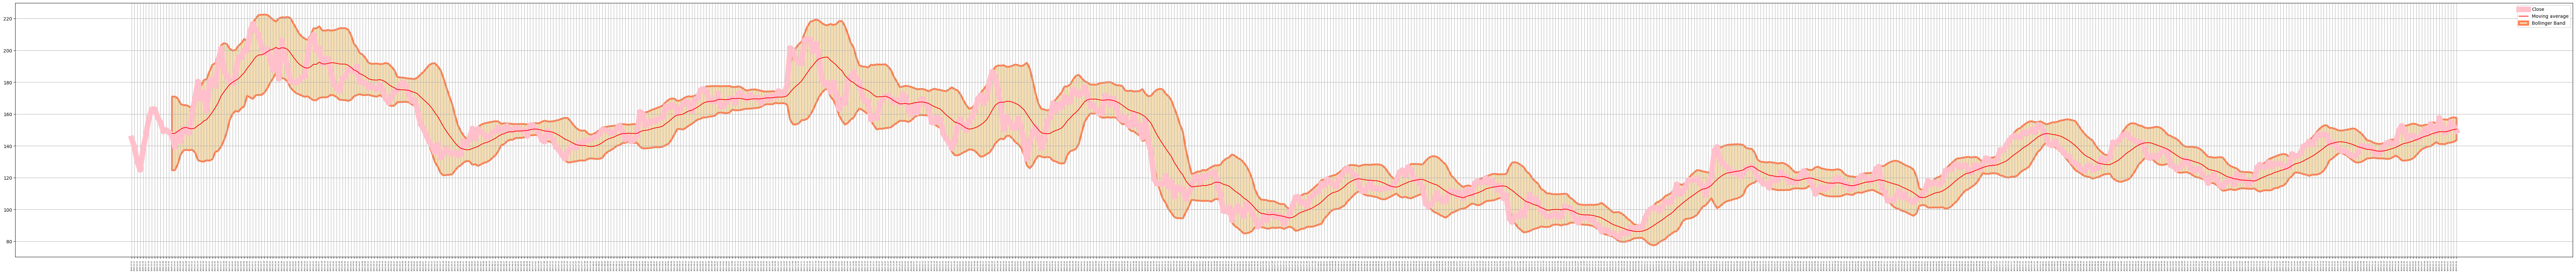

In [289]:
create_plot_with_MA_and_BB(test_data, len(test_data))

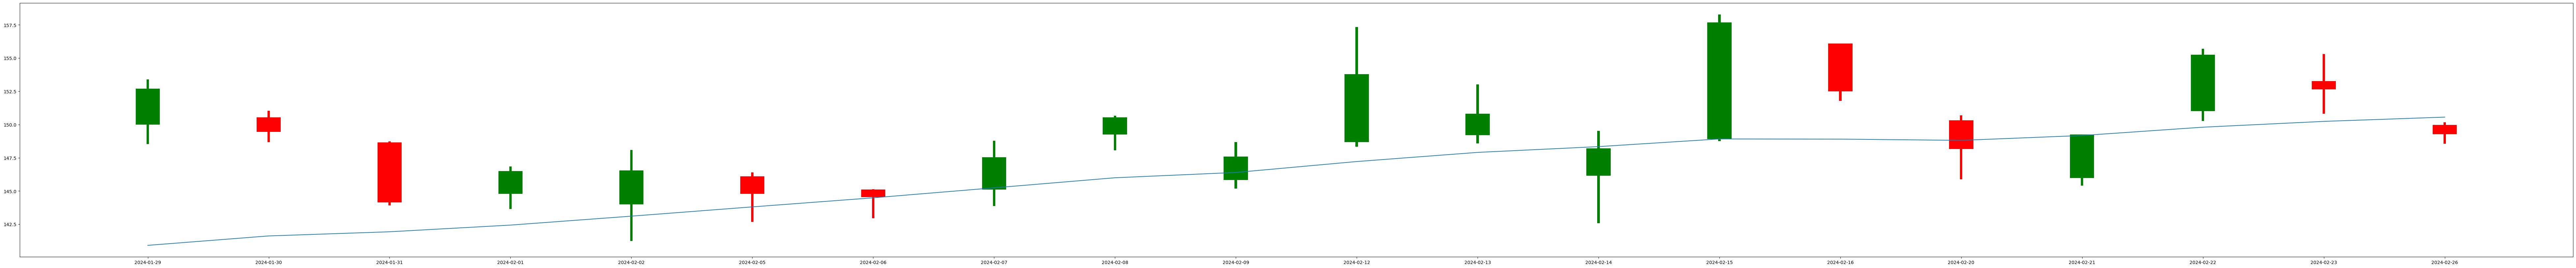

In [282]:
create_candles_graph(test_data[-20:]) 

In [257]:
calculate_atr(test_data, 14)
test_data.head(15)

,Date,Open,High,Low,Close,Volume,MA_14,Standard Deviation,BB_Upper_Bound,BB_Lower_Bound,Max_TR,ATR
0,2020-12-10,146.000,165.000,141.250,144.71,70447500,NaN,NaN,NaN,NaN,23.750,NaN
1,2020-12-11,146.550,151.500,135.100,139.25,26980800,NaN,NaN,NaN,NaN,16.400,NaN
2,2020-12-14,135.000,135.300,125.160,130.00,16966100,NaN,NaN,NaN,NaN,14.090,NaN
3,2020-12-15,126.690,127.600,121.500,124.80,10914400,NaN,NaN,NaN,NaN,8.500,NaN
4,2020-12-16,125.830,142.000,124.910,137.99,20409600,NaN,NaN,NaN,NaN,17.200,NaN
5,2020-12-17,143.000,152.450,142.670,147.05,15054700,NaN,NaN,NaN,NaN,14.460,NaN
6,2020-12-18,150.450,159.000,150.300,157.30,15954200,NaN,NaN,NaN,NaN,11.950,NaN
7,2020-12-21,155.310,172.000,145.110,163.02,17788100,NaN,NaN,NaN,NaN,26.890,NaN
8,2020-12-22,170.000,174.970,161.050,163.19,9872600,NaN,NaN,NaN,NaN,13.920,NaN
9,2020-12-23,162.814,168.250,155.500,158.01,5852500,NaN,NaN,NaN,NaN,12.750,NaN


In [258]:
calculate_atr(test_data, 14)
test_data

,Date,Open,High,Low,Close,Volume,MA_14,Standard Deviation,BB_Upper_Bound,BB_Lower_Bound,Max_TR,ATR
0,2020-12-10,146.00,165.00,141.250,144.71,70447500,NaN,NaN,NaN,NaN,23.750,NaN
1,2020-12-11,146.55,151.50,135.100,139.25,26980800,NaN,NaN,NaN,NaN,16.400,NaN
2,2020-12-14,135.00,135.30,125.160,130.00,16966100,NaN,NaN,NaN,NaN,14.090,NaN
3,2020-12-15,126.69,127.60,121.500,124.80,10914400,NaN,NaN,NaN,NaN,8.500,NaN
4,2020-12-16,125.83,142.00,124.910,137.99,20409600,NaN,NaN,NaN,NaN,17.200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
801,2024-02-20,150.31,150.68,145.880,148.15,5229700,148.810,3.875,156.560,141.060,6.630,5.435
802,2024-02-21,145.98,149.26,145.396,149.24,4570800,149.175,3.634,156.444,141.906,3.864,5.323
803,2024-02-22,151.02,155.70,150.265,155.26,6115000,149.801,3.883,157.568,142.034,6.460,5.404
804,2024-02-23,153.27,155.30,150.825,152.66,4845300,150.237,3.833,157.903,142.572,4.475,5.337


In [259]:
calculate_rsi(test_data)
test_data

,Date,Open,High,Low,Close,Volume,MA_14,Standard Deviation,BB_Upper_Bound,BB_Lower_Bound,Max_TR,ATR,Gain,Loss,AVG Gain,AVG Loss,RS,RSI
0,2020-12-10,146.00,165.00,141.250,144.71,70447500,NaN,NaN,NaN,NaN,23.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-11,146.55,151.50,135.100,139.25,26980800,NaN,NaN,NaN,NaN,16.400,NaN,0.00,5.46,NaN,NaN,NaN,NaN
2,2020-12-14,135.00,135.30,125.160,130.00,16966100,NaN,NaN,NaN,NaN,14.090,NaN,0.00,9.25,NaN,NaN,NaN,NaN
3,2020-12-15,126.69,127.60,121.500,124.80,10914400,NaN,NaN,NaN,NaN,8.500,NaN,0.00,5.20,NaN,NaN,NaN,NaN
4,2020-12-16,125.83,142.00,124.910,137.99,20409600,NaN,NaN,NaN,NaN,17.200,NaN,13.19,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,2024-02-20,150.31,150.68,145.880,148.15,5229700,148.810,3.875,156.560,141.060,6.630,5.435,0.00,4.36,1.707,1.575,1.084,52.012
802,2024-02-21,145.98,149.26,145.396,149.24,4570800,149.175,3.634,156.444,141.906,3.864,5.323,1.09,0.00,1.663,1.462,1.137,53.208
803,2024-02-22,151.02,155.70,150.265,155.26,6115000,149.801,3.883,157.568,142.034,6.460,5.404,6.02,0.00,1.974,1.358,1.454,59.246
804,2024-02-23,153.27,155.30,150.825,152.66,4845300,150.237,3.833,157.903,142.572,4.475,5.337,0.00,2.60,1.833,1.447,1.267,55.891


<h1><center>Calculating all variables together:<center/> </h1>

In [263]:
def calculate_all_stocks_related_data(stocks_df, 
                                      bb_day_range = 14,
                                      atr_day_range = 14, 
                                      rsi_day_range = 14, ):
    '''
        Function that calculates and collects all stocks-related data:
            1) Bollinger bands
            2) ATR
            3) RSI

        Return:
            A data frame which have all related columns calculated inside it
            
        Arguments:
            1) stocks_df - pandas data frame on which we will be performing operations
            2) bb_day_range - amount of days to serve as range for bollinger bands. By default - 14
            3) atr_day_range - amount of days to serve as range for ATR. By default - 14
            4) rsi_day_range - amount of days to serve as range for RSI. By default - 14
    '''
    calculate_bollinger_band(stocks_df, bb_day_range)
     
    
    calculate_atr(stocks_df, atr_day_range)
    calculate_rsi(stocks_df, rsi_day_range) 
    #stocks_df.fillna(0, inplace = True)
    
    
    

In [264]:
test_data = pd.read_csv("../Data/Consumer Discretionary/Airbnb Inc. Class A Common Stock.csv")

calculate_all_stocks_related_data(test_data)
test_data

,Date,Open,High,Low,Close,Volume,MA_14,Standard Deviation,BB_Upper_Bound,BB_Lower_Bound,Max_TR,ATR,Gain,Loss,AVG Gain,AVG Loss,RS,RSI
0,2020-12-10,146.00,165.00,141.250,144.71,70447500,NaN,NaN,NaN,NaN,23.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-11,146.55,151.50,135.100,139.25,26980800,NaN,NaN,NaN,NaN,16.400,NaN,0.00,5.46,NaN,NaN,NaN,NaN
2,2020-12-14,135.00,135.30,125.160,130.00,16966100,NaN,NaN,NaN,NaN,14.090,NaN,0.00,9.25,NaN,NaN,NaN,NaN
3,2020-12-15,126.69,127.60,121.500,124.80,10914400,NaN,NaN,NaN,NaN,8.500,NaN,0.00,5.20,NaN,NaN,NaN,NaN
4,2020-12-16,125.83,142.00,124.910,137.99,20409600,NaN,NaN,NaN,NaN,17.200,NaN,13.19,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,2024-02-20,150.31,150.68,145.880,148.15,5229700,148.810,3.875,156.560,141.060,6.630,5.435,0.00,4.36,1.707,1.575,1.084,52.012
802,2024-02-21,145.98,149.26,145.396,149.24,4570800,149.175,3.634,156.444,141.906,3.864,5.323,1.09,0.00,1.663,1.462,1.137,53.208
803,2024-02-22,151.02,155.70,150.265,155.26,6115000,149.801,3.883,157.568,142.034,6.460,5.404,6.02,0.00,1.974,1.358,1.454,59.246
804,2024-02-23,153.27,155.30,150.825,152.66,4845300,150.237,3.833,157.903,142.572,4.475,5.337,0.00,2.60,1.833,1.447,1.267,55.891


In [262]:
test_data = pd.read_csv("../Data/Consumer Discretionary/Airbnb Inc. Class A Common Stock.csv")
calculate_ma(test_data, 14)

In [290]:
def draw_RSI_line(stocks_data, days_range = 14):
    pass